## Imports and data loading: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing

In [2]:
def load_data(file_path):
    """Load stock market data from a CSV file."""
    try:
        data = pd.read_csv(file_path)
        data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y', errors='coerce')
        return data
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

## Preprocessing 

In [3]:
# making data stationaty 
def make_stationary(data, column='Close'):
    """Check stationarity and apply differencing if needed."""
    if not np.isfinite(data[column]).all():
        print(f"Warning: '{column}' contains non-finite values. Cleaning data...")
        data[column] = data[column].replace([np.inf, -np.inf], np.NaN).fillna(method='ffill')
        if data[column].isna().any():
            data[column] = data[column].fillna(method='bfill')  # Backup fill
    result = adfuller(data[column].dropna())
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value for {column}: {result[1]}')
    if result[1] > 0.05:
        print(f"Series '{column}' is non-stationary, applying differencing.")
        return data[column].diff().dropna()
    print(f"Series '{column}' is stationary.")
    return data[column]

In [4]:
data = load_data('../data/Stock_Market_Data.csv')
if data is not None:
    print("Columns in dataset:", data.columns.to_list())
    print("First few rows:\n", data.head())
    print("Data types:\n", data.dtypes)
    print("\nMissing values per column:\n", data.isna().sum())
    # Added: Check unique stock names
    print("\nUnique stock names:", data['Name'].unique())

Columns in dataset: ['Date', 'Name', 'Open', 'High', 'Low', 'Close', 'Volume']
First few rows:
         Date     Name   Open   High    Low  Close      Volume
0 2022-01-02  01.Bank  22.83  23.20  22.59  22.93  1842350.41
1 2022-01-03  01.Bank  23.03  23.29  22.74  22.90  1664989.63
2 2022-01-04  01.Bank  22.85  23.13  22.64  22.84  1354510.97
3 2022-01-05  01.Bank  22.91  23.20  22.70  22.98  1564334.81
4 2022-01-06  01.Bank  23.12  23.65  23.00  23.37  2586344.19
Data types:
 Date      datetime64[ns]
Name              object
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

Missing values per column:
 Date      0
Name      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Unique stock names: ['01.Bank' '02.Cement' '03.Ceramics_Sector' '04.Engineering'
 '05.Financial_Institutions' '06.Food_&_Allied' '07.Fuel_&_Power'
 '08.Insurance' '09.IT_Sector' '10.Jute' '11.Miscellaneo

#### preprocessing data for 01.Bank

In [5]:
if data is not None:
    stock_name = '01.Bank'
    data_stock = data[data['Name'] == stock_name].copy()
    if data_stock.empty:
        print(f"Error: No data found for stock '{stock_name}'. Check stock names above.")
    else:
        print(f"\nSelected stock: {stock_name}")
        data_stock.set_index('Date', inplace=True)
        data_stock = data_stock.drop(columns=['Name'])
        data_stock = data_stock.replace([np.inf, -np.inf], np.NaN)
        data_stock = data_stock.asfreq('D', method='ffill')
        print("\nMissing values after preprocessing:\n", data_stock.isna().sum())
        print("Data types after preprocessing:\n", data_stock.dtypes)


Selected stock: 01.Bank

Missing values after preprocessing:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Data types after preprocessing:
 Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [6]:
# summarty stats
if data is not None and not data_stock.empty:
    print("\nSummary Statistics for", stock_name, ":\n", data_stock.describe().to_string())
    numeric_cols = data_stock.select_dtypes(include=[np.number]).columns
    print("\nNumeric columns:", numeric_cols.to_list())


Summary Statistics for 01.Bank :
              Open        High         Low       Close        Volume
count  180.000000  180.000000  180.000000  180.000000  1.800000e+02
mean    21.296333   21.530944   21.056389   21.262500  1.116109e+06
std      1.307369    1.315051    1.294543    1.302112  4.468771e+05
min     19.080000   19.330000   18.940000   19.170000  4.952475e+05
25%     20.150000   20.330000   19.930000   20.060000  8.054306e+05
50%     21.450000   21.670000   21.140000   21.280000  1.027389e+06
75%     22.555000   22.835000   22.330000   22.582500  1.311673e+06
max     23.470000   23.650000   23.000000   23.370000  2.844397e+06

Numeric columns: ['Open', 'High', 'Low', 'Close', 'Volume']


## Detailed EDA : 

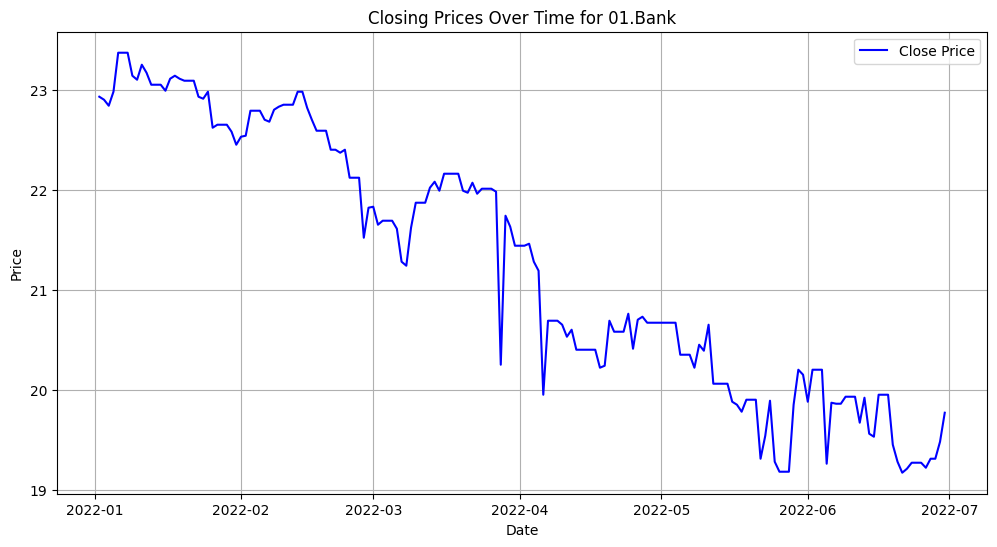

In [7]:
# closing prices
if data is not None and not data_stock.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(data_stock.index, data_stock['Close'], label='Close Price', color='blue')
    plt.title(f'Closing Prices Over Time for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

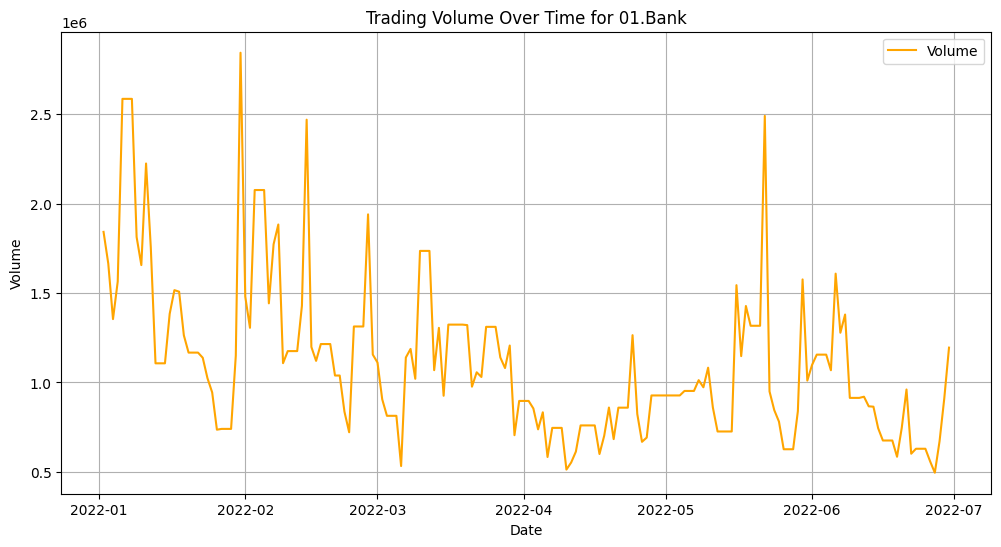

In [8]:
#  Plotting trading volume
if data is not None and not data_stock.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(data_stock.index, data_stock['Volume'], label='Volume', color='orange')
    plt.title(f'Trading Volume Over Time for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

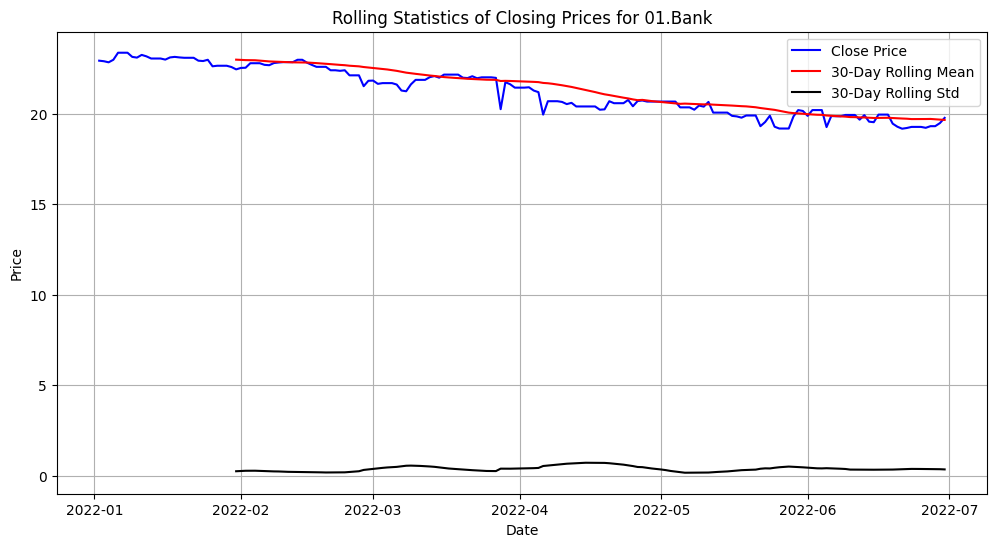

In [9]:
# Rolling mean and standard deviation
if data is not None and not data_stock.empty:
    rolling_mean = data_stock['Close'].rolling(window=30).mean()
    rolling_std = data_stock['Close'].rolling(window=30).std()
    plt.figure(figsize=(12, 6))
    plt.plot(data_stock.index, data_stock['Close'], label='Close Price', color='blue')
    plt.plot(rolling_mean.index, rolling_mean, label='30-Day Rolling Mean', color='red')
    plt.plot(rolling_std.index, rolling_std, label='30-Day Rolling Std', color='black')
    plt.title(f'Rolling Statistics of Closing Prices for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

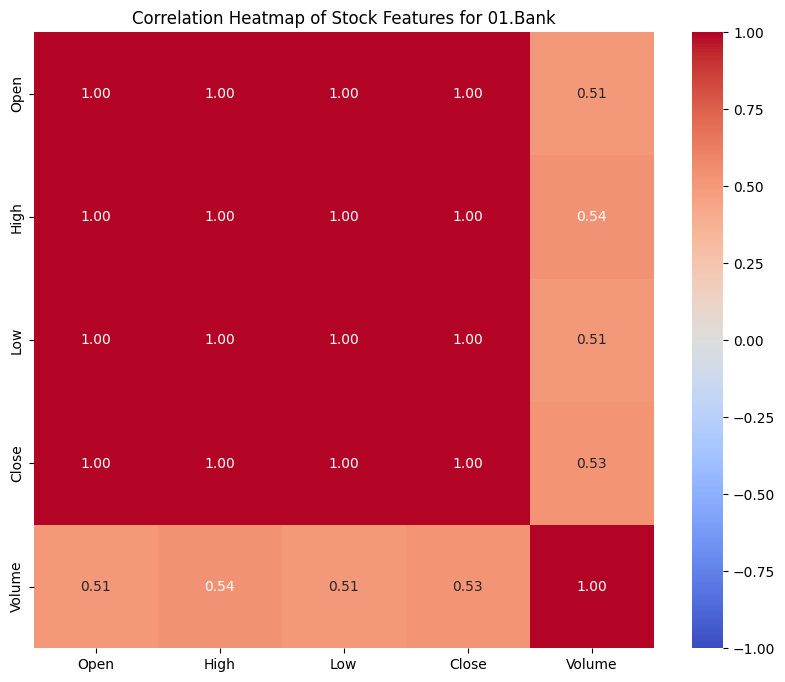

In [10]:
# Correlation heatmap
if data is not None and not data_stock.empty:
    plt.figure(figsize=(10, 8))
    sns.heatmap(data_stock[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title(f'Correlation Heatmap of Stock Features for {stock_name}')
    plt.show()

ADF Statistic for Close: -0.8409265810431817
p-value for Close: 0.8068036934645146
Series 'Close' is non-stationary, applying differencing.


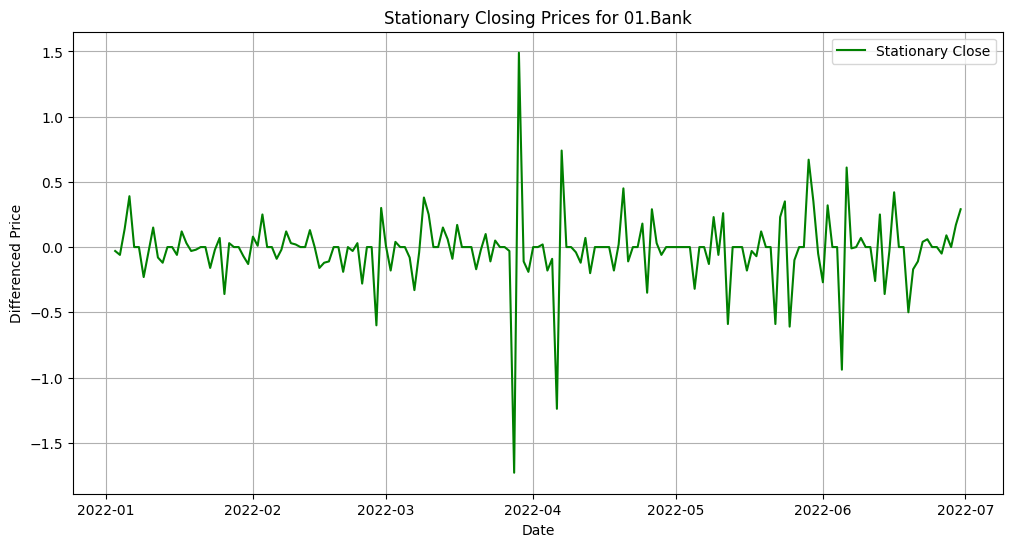

In [11]:
# Making closing price stationary
if data is not None and not data_stock.empty:
    stationary_close = make_stationary(data_stock, 'Close')
    if stationary_close is None or len(stationary_close) == 0:
        print("Error: Stationary data is empty after processing.")
    else:
        plt.figure(figsize=(12, 6))
        plt.plot(stationary_close.index, stationary_close, label='Stationary Close', color='green')
        plt.title(f'Stationary Closing Prices for {stock_name}')
        plt.xlabel('Date')
        plt.ylabel('Differenced Price')
        plt.legend()
        plt.grid(True)
        plt.show()

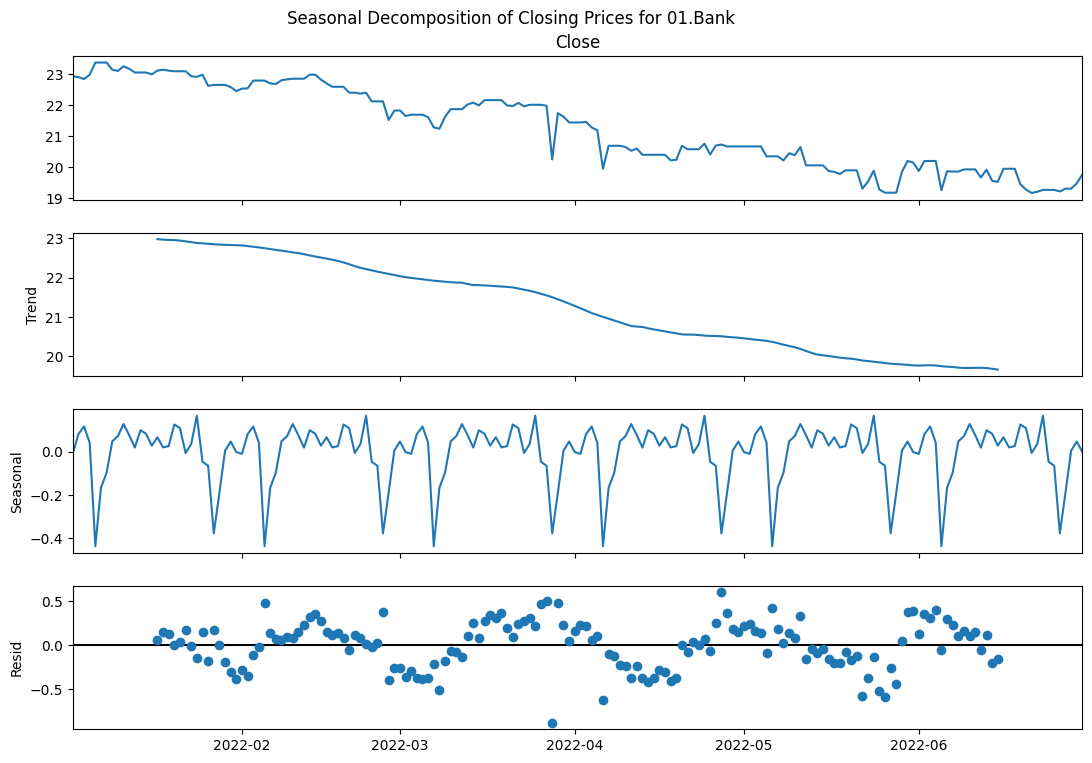

In [12]:
# seasonal decomposition
if data is not None and not data_stock.empty:
    decomposition = seasonal_decompose(data_stock['Close'], model='additive', period=30)  # Monthly seasonality
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f'Seasonal Decomposition of Closing Prices for {stock_name}')
    plt.show()

In [13]:
# calculating daily returns
if data is not None and not data_stock.empty:
    data_stock['Return'] = data_stock['Close'].pct_change()

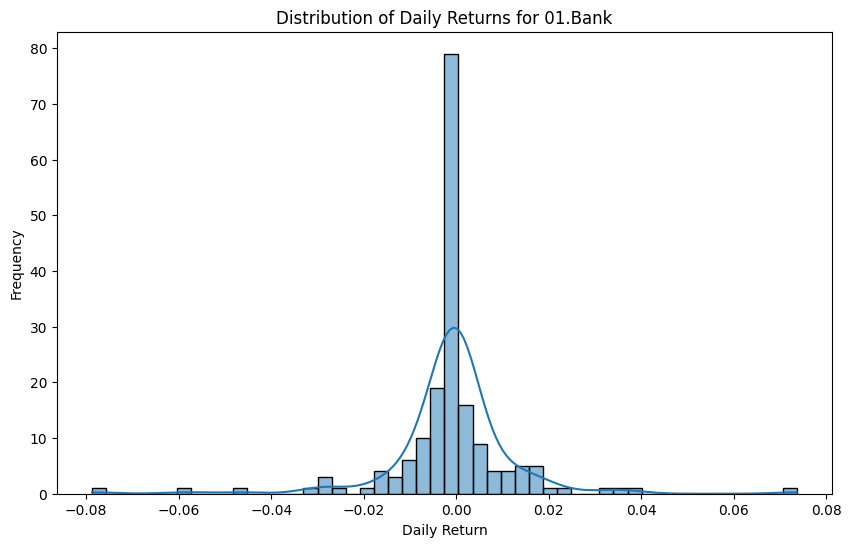

In [14]:
# distribution of daily returns
if data is not None and not data_stock.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_stock['Return'].dropna(), bins=50, kde=True)
    plt.title(f'Distribution of Daily Returns for {stock_name}')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.show()

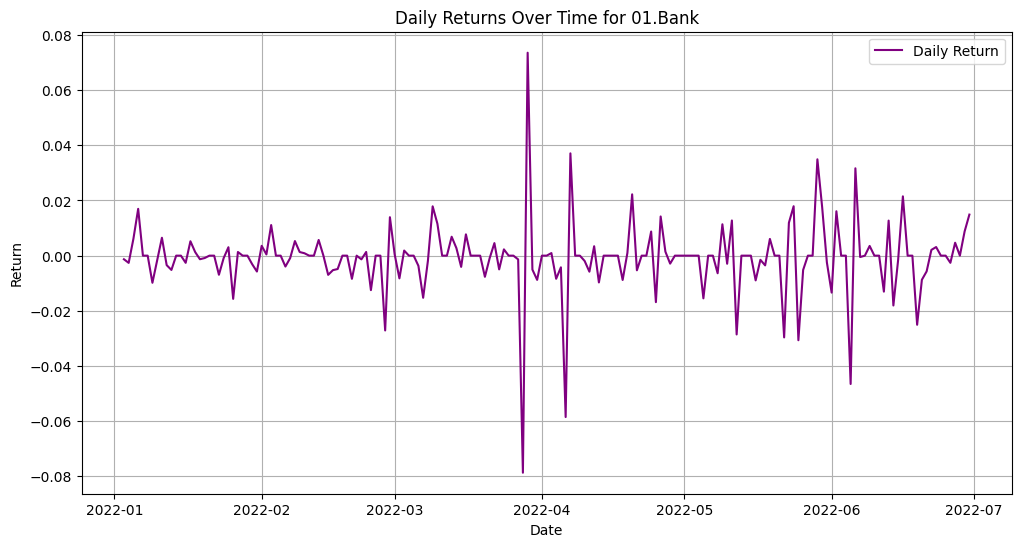

In [15]:
# daily returns over time
if data is not None and not data_stock.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(data_stock.index, data_stock['Return'], label='Daily Return', color='purple')
    plt.title(f'Daily Returns Over Time for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.show()

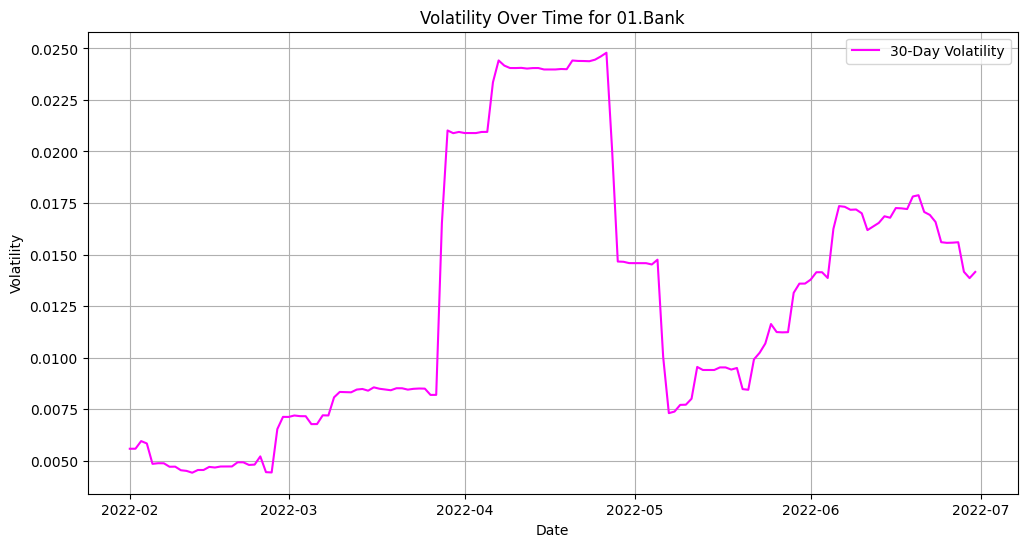

In [16]:
# vlatility over time
if data is not None and not data_stock.empty:
    data_stock['Volatility'] = data_stock['Return'].rolling(window=30).std()
    plt.figure(figsize=(12, 6))
    plt.plot(data_stock.index, data_stock['Volatility'], label='30-Day Volatility', color='magenta')
    plt.title(f'Volatility Over Time for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

<Figure size 1200x600 with 0 Axes>

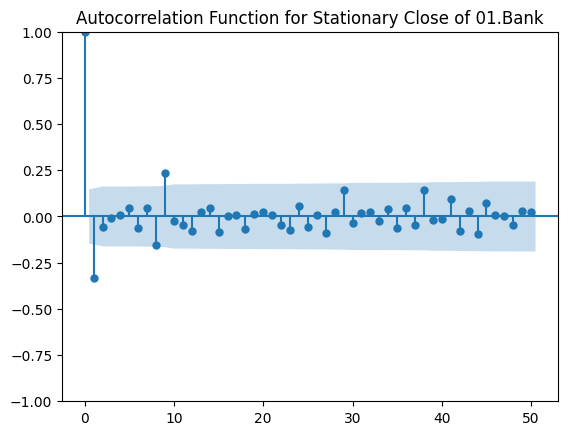

<Figure size 1200x600 with 0 Axes>

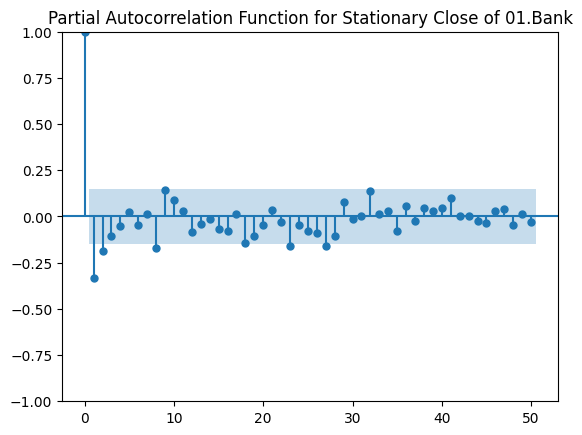

In [17]:
# autocorrelation and partial autocorrelation
if data is not None and not data_stock.empty and stationary_close is not None:
    plt.figure(figsize=(12, 6))
    plot_acf(stationary_close, lags=50)
    plt.title(f'Autocorrelation Function for Stationary Close of {stock_name}')
    plt.show()

    plt.figure(figsize=(12, 6))
    plot_pacf(stationary_close, lags=50)
    plt.title(f'Partial Autocorrelation Function for Stationary Close of {stock_name}')
    plt.show()

##  outlier detection


Outlier dates:
 DatetimeIndex(['2022-03-28', '2022-03-29', '2022-04-06', '2022-06-05'], dtype='datetime64[ns]', name='Date', freq=None)


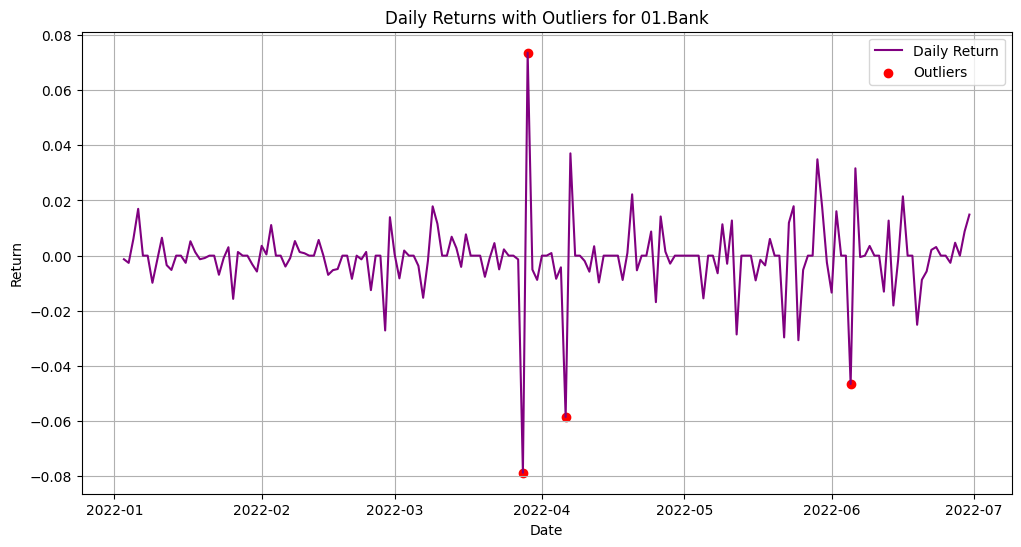

In [18]:
if data is not None and not data_stock.empty:
    mean_return = data_stock['Return'].mean()
    std_return = data_stock['Return'].std()
    outliers = data_stock[(data_stock['Return'] > mean_return + 3 * std_return) | 
                          (data_stock['Return'] < mean_return - 3 * std_return)]
    print("Outlier dates:\n", outliers.index)
    plt.figure(figsize=(12, 6))
    plt.plot(data_stock.index, data_stock['Return'], label='Daily Return', color='purple')
    plt.scatter(outliers.index, outliers['Return'], color='red', label='Outliers')
    plt.title(f'Daily Returns with Outliers for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.show()

## Comparative Analysis : selecting multiple stocks


In [19]:
if data is not None:
    stock_names = data['Name'].unique()[:3]  # Select first three unique stocks
    print("Selected stocks for comparison:", stock_names)
    data_stocks = data[data['Name'].isin(stock_names)].copy()


Selected stocks for comparison: ['01.Bank' '02.Cement' '03.Ceramics_Sector']


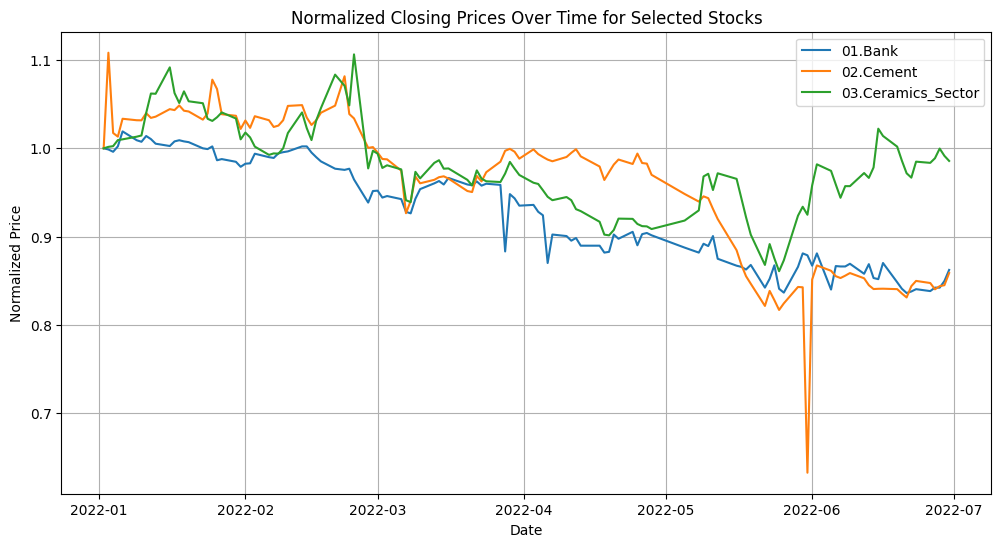

In [20]:
## normalized closing prices for multiple stocks
if data is not None and 'data_stocks' in locals():
    closing_prices = data_stocks.pivot(index='Date', columns='Name', values='Close')
    normalized_closing = closing_prices / closing_prices.iloc[0]
    plt.figure(figsize=(12, 6))
    for stock in normalized_closing.columns:
        plt.plot(normalized_closing.index, normalized_closing[stock], label=stock)
    plt.title('Normalized Closing Prices Over Time for Selected Stocks')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)
    plt.show()

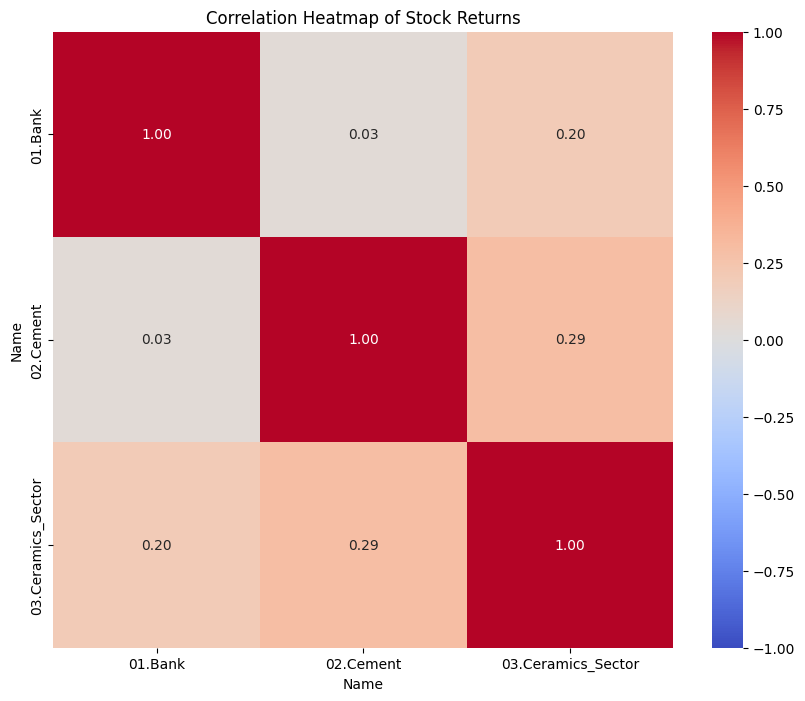

In [21]:


# heatmap of stock returns
if data is not None and 'data_stocks' in locals():
    returns = closing_prices.pct_change().dropna()
    correlation_matrix = returns.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Heatmap of Stock Returns')
    plt.show()